In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image                                 #create image from array
from datetime import datetime                         #date for submission file
from  scipy import ndimage
from sklearn.preprocessing import normalize

import tensorflow as tf

# CNN libraries (keras)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K 

import matplotlib.pyplot as plt

#Personal libraries
from mask_to_submission import *
from submission_to_mask import *


%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
SEED = 34342
PATCH_SIZE = 16
NUMBER_TRAIN_IMG = 50 # max 100
DATA_ROOT_DIR = "Datasets/"
SUBMISSION_DIR= "Submissions/"
PREDICTION_DIR= "Predictions/"
CONTEXT = 10
NB_CLASSES = 2
NB_EPOCHS = 100

np.random.seed(SEED)  # for reproducibility

### 1) Loading the set of images

In [3]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def LoadTrainingData(n_img, rootdir="Datasets/training/", printnames=False):
    """ Load the data from the root directory. (a total of n_img images) """

    image_dir = rootdir + "images/"
    files = os.listdir(image_dir)

    n = min(n_img, len(files)) # Load maximum 20 images
    print("Loading " + str(n) + " train images...")
    imgs = [load_image(image_dir + files[i]) for i in range(n)]

    gt_dir = rootdir + "groundtruth/"
    print("Loading " + str(n) + " groundtruth images...")
    gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

    if (printnames):
        print("The loaded images are: ")
        for i in range(n):
            print("    - " + files[i])
    
    return imgs, gt_imgs

In [4]:
traindir = DATA_ROOT_DIR + "training/"
imagedir = traindir + "images/"

# list with all the available images name
files = os.listdir(imagedir) 

n = NUMBER_TRAIN_IMG
imgs, gt_imgs = LoadTrainingData(n, traindir)

Loading 50 train images...
Loading 50 groundtruth images...


### 2) Data augmentation

In [5]:
# The augmented data will present itself as follows: 
# [original img, 90° rotation, 180° rotation, 270° rotation, 
#  symmetry original img, sym 90° rot img, sym 180° rot img, sym 270° img]

def DataAugmentation(imgs, gt_imgs, angles, sym=False, printinfo=False):
    """
    Augments the data by rotating the image with the angles given in the list <angles>.
    If <sym> is true, it also augments the the data with the images obtained by performing a
    y axis symmetry.
    
    The augmented data will present itself as follows: 
        
        [angles[1] rotations, ..., angles[end] rotations,
        Y axis symmetry of the angles[1] rotations, ..., Y axis symmetry of the angles[end] rotations]
 
    """
    n = len(imgs)
    
    # Creating the augmented version of the images.
    aug_imgs = []
    aug_gt_imgs = []
    
    # Rotating the images and adding them to the augmented data list
    for theta in angles:
        if (printinfo):
            print("Augmenting the data with the images rotated by", theta , "deg.")
        aug_imgs += [BuildRotatedImage(imgs[i], theta) for i in range(n)]
        aug_gt_imgs += [BuildRotatedImage(gt_imgs[i], theta) for i in range(n)]  
        
    # Y symmetry of the images and adding them to the augmented dat list
    if (sym):
        if (printinfo):
            print("Augmenting the data with the symmetries")
        n_tmp = len(aug_imgs)
        aug_imgs += [np.flip(aug_imgs[i],1) for i in range(n_tmp)]
        aug_gt_imgs += [np.flip(aug_gt_imgs[i],1) for i in range(n_tmp)]
        
    return aug_imgs, aug_gt_imgs

    
def BuildExtendedImage(img):
    """ Create a 3x3 grid of the imput image by mirroring it at the boundaries"""

    top_and_lower_row = np.concatenate((np.flip(np.flip(img,0),1), np.flip(img,0), np.flip(np.flip(img,0),1)), axis=1)
    mid_row = np.concatenate((np.flip(img,1), img, np.flip(img,1)), 1)
    
    ext_img = np.concatenate((top_and_lower_row, mid_row, top_and_lower_row), 0)
       
    return ext_img

def BuildRotatedImage(img, degree):
    """ Return the same image rataded by <degree> degrees. The corners are filled using mirrored boundaries. """
    
    # Improving performance using existing functions for specific angles
    if (degree==0):
        return img
    elif (degree==90):
        return np.rot90(img)
    elif (degree==180):
        return np.rot90(np.rot90(img))
    elif (degree==270):
        return np.rot90(np.rot90(np.rot90(img)))
    else:
        h = img.shape[0]
        w = img.shape[1]

        # Extend and rotate the image
        ext_img = BuildExtendedImage(img)
        rot_img = ndimage.rotate(ext_img, degree, reshape=False)

        # Taking care of nummerical accuracies (not sure where they come from)

        rot_img[rot_img<0] = 0.0
        rot_img[rot_img>1] = 1.0

        # Crop the image
        if (len(img.shape) > 2):
            rot_img = rot_img[h:2*h, w:2*w, :]
        else:
            rot_img = rot_img[h:2*h, w:2*w]
        
        return rot_img

In [6]:
# Augmenting the data
angles = [0, 45]
aug_imgs, aug_gt_imgs = DataAugmentation(imgs, gt_imgs, angles)

print("(Augmented) number of images (and groundtruth): ", len(aug_imgs))

(Augmented) number of images (and groundtruth):  100


### 3) Extract patches

In [7]:
def img_crop(im, w, h, c=0):
    """ Personalized version of the img_crop incorporating the option of getting the context (c) around the pataches"""
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    
    # padding the image to access the context of border patches
    if is_2d:
        pad_im = np.pad(im,((c,c),(c,c)), 'reflect')
    else:
        pad_im = np.pad(im,((c,c),(c,c),(0,0)), 'reflect')

    # cropping the image
    for i in range(c,imgheight+c,h):
        for j in range(c,imgwidth+c,w):
            if is_2d:
                im_patch = pad_im[j-c:(j+w)+c, i-c:(i+h)+c]
            else:
                im_patch = pad_im[j-c:(j+w)+c, i-c:(i+h)+c, :]

            list_patches.append(im_patch)
    return list_patches

def ExtractTrainPatch(imgs, gt_imgs, context=0, balancing=True):
    """ Extract patches of size patch_size from the input images.  """ 
    n = len(imgs)
    
    img_patches = [img_crop(imgs[i], PATCH_SIZE, PATCH_SIZE, context) for i in range(n)]
    gt_patches = [img_crop(gt_imgs[i], PATCH_SIZE, PATCH_SIZE) for i in range(n)]


    # Linearize list of patches
    
    X = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    Y = np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    
    return X, Y

In [8]:
img_patches, gt_patches = ExtractTrainPatch(aug_imgs, aug_gt_imgs, CONTEXT, True)

print("img_patches has size ", img_patches.shape)
print("gt_patches has size ", gt_patches.shape)

#plt.imshow(img_patches[477], cmap='Greys_r')

img_patches has size  (62500, 36, 36, 3)
gt_patches has size  (62500, 16, 16)


### 4) Extract features

In [9]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))   
    features = np.append(feat_m, feat_v)
    return features

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img_raw = load_image(filename)
    img_patches = img_crop(img, PATCH_SIZE, PATCH_SIZE)
    X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
    return X, img, img_raw


def value_to_class(v, foreground_threshold):
    df = np.mean(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def PrintFeatureStatistics(X, Y):
    print('There are ' + str(X.shape[0]) + ' data points (patches)')
    print('The size of the patches is ' + str(X.shape[1]) + 'x' 
          + str(X.shape[2]) + ' = ' + str(X.shape[1]*X.shape[2]) +" pixels")

    print('Number of classes = ' + str(len(np.unique(Y))))

    Y0 = [i for i, j in enumerate(Y) if j == 0]
    Y1 = [i for i, j in enumerate(Y) if j == 1]
    print('Class 0 (background): ' + str(len(Y0)) + ' samples')
    print('Class 1 (signal): ' + str(len(Y1)) + ' samples')
    print('Proportion of road: ', len(Y1)/(len(Y1)+len(Y0)))
    print('Proportion of background: ', len(Y0)/(len(Y1)+len(Y0)))

def NormalizeFeatures(X):
    """Normalize X which must have shape (num_data_points,num_features)"""
    m = np.mean(X,axis=0)
    s = np.std(X,axis=0)
    
    return (X-m)/s

def Balancing(X_train, Y_train):
    c0 = 0  # bgrd
    c1 = 0  # road
    for i in range(len(Y_train)):
        if Y_train[i] == 0:
            c0 = c0 + 1
        else:
            c1 = c1 + 1
    print('Number of data points per class (before balancing): c0 = ' + str(c0) + ' c1 = ' + str(c1))

    print('Balancing training data...')
    min_c = min(c0, c1)
    idx0 = [i for i in range(len(Y_train)) if Y_train[i] == 0]
    idx1 = [i for i in range(len(Y_train)) if Y_train[i] == 1]
    indices = idx0[0:min_c] + idx1[0:min_c]
    new_indices = np.random.permutation(indices)
    
    X_balanced = X_train[new_indices]
    Y_balanced = Y_train[new_indices]

    c0 = 0
    c1 = 0
    for i in range(len(Y_balanced)):
        if Y_balanced[i] == 0:
            c0 = c0 + 1
        else:
            c1 = c1 + 1
    print('Number of data points per class (after balancing): c0 = ' + str(c0) + ' c1 = ' + str(c1))
    
    return X_balanced, Y_balanced



In [10]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

#X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
X_tr_raw = np.copy(img_patches)
Y_tr_raw = np.asarray([value_to_class(gt_patches[i], foreground_threshold) for i in range(len(gt_patches))])

X_tr_bal, Y_tr_bal = Balancing(X_tr_raw, Y_tr_raw)

Number of data points per class (before balancing): c0 = 46758 c1 = 15742
Balancing training data...
Number of data points per class (after balancing): c0 = 15742 c1 = 15742


In [11]:
# Print feature statistics
PrintFeatureStatistics(X_tr_bal, Y_tr_bal)

There are 31484 data points (patches)
The size of the patches is 36x36 = 1296 pixels
Number of classes = 2
Class 0 (background): 15742 samples
Class 1 (signal): 15742 samples
Proportion of road:  0.5
Proportion of background:  0.5


### 5) CNN model definition

In [12]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

def TruePositiveRate(tX, Y, logregModel):
    """Compute the true positive rate of the lgistic regression model logregModel on 
       the training augmented data tX.
    """
    # Predict on the training set
    Y_pred = logregModel.predict(tX)
    
    # Get non-zeros in prediction and grountruth arrays
    Y_predn = np.nonzero(Y_pred)[0]
    Yn = np.nonzero(Y)[0]

    TPR = len(list(set(Yn) & set(Y_predn))) / float(len(Yn))
    return TPR
    

In [13]:
# number of convolutional filters to use
nb_filters = 10

# size of pooling area for max pooling
pool_size = (2, 2)

# convolution kernel size
kernel_size = (5, 5)

# convert class vectors to binary class matrices
Y_tr = np_utils.to_categorical(Y_tr_bal, NB_CLASSES)

# normalizing the training data
#X_tr = tf.keras.utils.normalize(X_tr_bal, axis=(1,2)) # TODO
X_tr = np.copy(X_tr_bal).astype('float32')

# input size
input_shape = (X_tr.shape[1], X_tr.shape[2], X_tr.shape[3])

K.clear_session()
model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size, padding='valid', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary();

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 10)        760       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 10)        2510      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 10)        0         
________________________________________________

In [14]:
#Deleting unused variables
del X_tr_bal, X_tr_raw, Y_tr_bal, Y_tr_raw, imgs, gt_imgs, img_patches, gt_patches, aug_imgs, aug_gt_imgs

In [15]:
history = model.fit(X_tr, Y_tr, batch_size=X_tr.shape[0], epochs=NB_EPOCHS, verbose=2, validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 25187 samples, validate on 6297 samples
Epoch 1/100
 - 97s - loss: 0.6963 - accuracy: 0.5101 - val_loss: 0.7017 - val_accuracy: 0.4993
Epoch 2/100
 - 89s - loss: 0.7032 - accuracy: 0.5003 - val_loss: 0.6944 - val_accuracy: 0.5069
Epoch 3/100
 - 98s - loss: 0.6951 - accuracy: 0.5067 - val_loss: 0.6917 - val_accuracy: 0.5415
Epoch 4/100
 - 101s - loss: 0.6922 - accuracy: 0.5247 - val_loss: 0.6901 - val_accuracy: 0.5452
Epoch 5/100
 - 96s - loss: 0.6904 - accuracy: 0.5334 - val_loss: 0.6886 - val_accuracy: 0.5303
Epoch 6/100
 - 101s - loss: 0.6890 - accuracy: 0.5312 - val_loss: 0.6866 - val_accuracy: 0.5636
Epoch 7/100
 - 100s - loss: 0.6870 - accuracy: 0.5535 - val_loss: 0.6841 - val_accuracy: 0.5698
Epoch 8/100
 - 98s - loss: 0.6846 - accuracy: 0.5655 - val_loss: 0.6806 - val_accuracy: 0.6354
Epoch 9/100
 - 93s - loss: 0.6822 - accuracy: 0.5976 - val_loss: 0.6807 - val_accuracy: 0.5209
Epoch 10/100
 - 102s - loss: 0.6817 - accurac

KeyboardInterrupt: 

### 6) CNN model training

In [16]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

score = model.evaluate(X_tr, Y_tr, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

NameError: name 'history' is not defined

In [130]:
def ExtractTestPatch(img, context=0):
    """ Extract patches of size patch_size from the input image.""" 


    img_patches = img_crop(img, PATCH_SIZE, PATCH_SIZE, context)
    
    # Linearize list of patches
    img_patches = np.asarray([img_patches[i]
                              for i in range(len(img_patches))])
    return img_patches

def CreateSubmission(CNNmodel):
    """ Create a submission file using the trained logregModel."""
    # paths
    test_rootdir = DATA_ROOT_DIR + "test_set_images/"
    test_files = os.listdir(test_rootdir)
    
    prediction_filenames = []
    
    # Prediction of all the test images
    for i  in range(len(test_files)):
        print("Predicting image" + test_files[i] + "...")
        # Image path of the i-th image
        img_path = test_rootdir + test_files[i] + "/" + test_files[i] + ".png"
        
        # Extraction of the data feature
        img = load_image(img_path)
        Xi = ExtractTestPatch(img, CONTEXT)
        
        # Prediction of the i-th image using the trained model logregModel
        Yi_prob = CNNmodel.predict(Xi, verbose=0)
        Yi_pred = np.argmax(Yi_prob, axis=1)
        
        # Construction of the mask
        w = img.shape[0]
        h = img.shape[1]
        predicted_mask = label_to_img(w, h, PATCH_SIZE, PATCH_SIZE, Yi_pred)
        
        # Creating the name for the predicted mask
        img_id = int(re.search(r"\d+", test_files[i]).group(0))
        prediction_filenames += [PREDICTION_DIR + "prediction_" + "%.3d" % img_id + ".png"]
        
        # Saving the masks in the preddir folder
        Image.fromarray(binary_to_uint8(predicted_mask)).save(prediction_filenames[i])  
    
    # Create unique filename
    now = datetime.now()
    dt_string = now.strftime("%H_%M__%d_%m")
    submission_filename = SUBMISSION_DIR + "submission_CNN_" + dt_string + ".csv"
    
    # Create submission
    print("Creating submission file...")
    masks_to_submission(submission_filename, prediction_filenames)

In [ ]:
CreateSubmission(model)

In [136]:
def VisualizeCNNPrediction(CNNModel, img_ind):
    
    test_rootdir = DATA_ROOT_DIR + "test_set_images/"
    test_files = os.listdir(test_rootdir)
    img_path = test_rootdir + test_files[img_ind] + "/" + test_files[img_ind] + ".png"
    
    img = load_image(img_path)
    Xi = ExtractTestPatch(img, CONTEXT)
    Yi_prob = CNNModel.predict(Xi, verbose=0)
    Yi_pred = np.argmax(Yi_prob, axis=1)
    print("Number of predicted road patches: ", Yi_pred.sum())
    # Display prediction as an image

    w = img.shape[0]
    h = img.shape[1]
    predicted_im = label_to_img(w, h, PATCH_SIZE, PATCH_SIZE, Yi_pred)
    cimg = make_img_overlay(img, predicted_im)
    fig1 = plt.figure(figsize=(8, 4)) 
    fig1.suptitle(img_path + "\nImage (left) and prediction (right)")
    plt.imshow(cimg, cmap='Greys_r')

Number of predicted road patches:  23


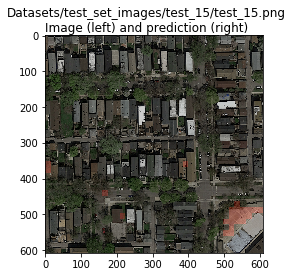

In [139]:
VisualizeCNNPrediction(model, 9)
